# Model Validation

An important piece of machine learning is **model validation** : that is, determining how well your model will generalize from the training data to future unlabeled data. Let's look at an example using the *KNN classifier* with the iris dataset:

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA

In [7]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
y_pred = clf.predict(X)
print(np.all(y == y_pred))

True


A more useful way to look at the results is to view the **confusion matrix**, or the matrix showing the frequency of inputs and outputs:

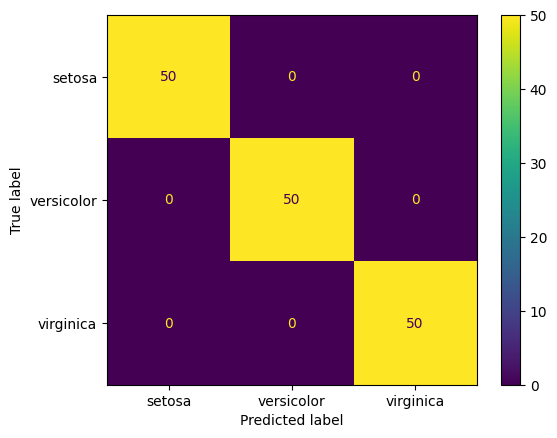

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#confusion matrix before data splitting
cmx = confusion_matrix(y, y_pred, labels= [0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix = cmx,
                             display_labels = iris.target_names)
disp.plot()
plt.show()

For each class, all 50 training samples are correctly identified. But this **does not mean that our model is perfect!** In particular, such a model generalizes extremely poorly to new data. We can simulate this by splitting our data into a *training set* and a *testing set*. Scikit-learn contains some convenient routines to do this:

In [9]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(Xtrain.shape)
print(Xtest.shape)

(120, 4)
(30, 4)


In [10]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

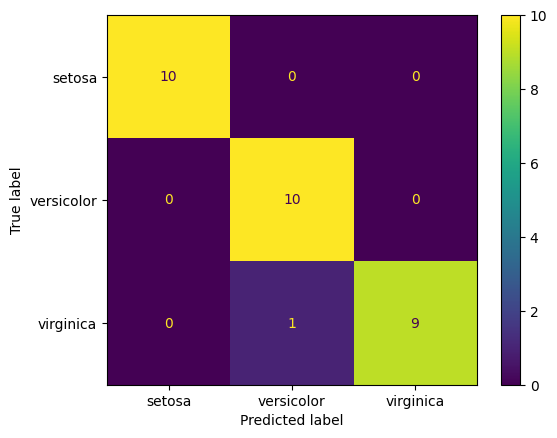

In [11]:
#confusion matrix after data splitting
cmx = confusion_matrix(ytest, ypred, labels= [0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix = cmx,
                             display_labels = iris.target_names)
disp.plot()
plt.show()

The metric we're using here, comparing the number of matches to the total number of samples, is known as the **accuracy score**, and can be computed using the following routine:

In [12]:
#Using KNeighborsClassifier 'score' method
mean_acc = clf.score(Xtest,ytest) # Mean accuracy of self.predict(X)
print(mean_acc*100)

96.66666666666667


This gives us a more reliable estimate of how our model is doing.

In [13]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(ytest,clf.predict(Xtest))
print(acc*100)

96.66666666666667


Now we can see how changing input parameters of the model (knows as **hyperparameters**) can change the results:

In [14]:
for n_neighbors in [1, 3, 5]:
    clf = KNeighborsClassifier(n_neighbors)
    clf.fit(Xtrain, ytrain)
    print(n_neighbors, clf.score(Xtest, ytest))

1 0.9666666666666667
3 1.0
5 1.0


# Model Selection: GridSearchCV

The performance of a model significantly depends on the value of hyperparameters. **GridSearchCV** is the process of performing hyperparameter tuning in order to determine the optimal values for a given model.

Note that there is no way to know in advance the best values for hyperparameters so ideally, we need to try all possible values to know the optimal values. Doing this manually could take a considerable amount of time and resources and thus we use GridSearchCV to automate the tuning of hyperparameters.

In [15]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

In [16]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.989 (+/-0.006) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.970 (+/-0.013) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.991 (+/-0.006) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.987 (+/-0.013) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.991 (+/-0.006) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.988 (+/-0.013) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.991 (+/-0.006) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.988 (+/-0.013) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.984 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.984 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.984 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.984 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed o